In [2]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

# Generate sample data for Wind Direction
with pm.Model() as direction_speed_sampler:
    # Define the circular transform for Wind Direction
    direction_transform = pm.distributions.transforms.circular

    # Define the prior distribution for Wind Direction
    direction = pm.Normal('direction', mu=.5, sigma=.2, transform=direction_transform)

    # Generate the observed data for Wind Direction
    #direction_observed = pm.Normal('direction_observed', mu=direction, sigma=0.1, observed=np.random.randn(100))

    # Generate sample data for Wind Speed

    # Define the prior distribution for Wind Speed
    speed = pm.HalfNormal('speed', sigma=10)

    # Generate the observed data for Wind Speed
    #speed_observed = pm.Normal('speed_observed', mu=speed, sigma=0.1, observed=np.random.randn(100))


In [3]:

def xr_downselect(xr_orig, coordinate, step):
    return xr_orig.sel({f'{coordinate}':xr_orig[f'{coordinate}']%step==0})


In [4]:
with direction_speed_sampler:
    samples = pm.sample(10, chains=1, tune=1000)


Only 10 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [direction, speed]


Sampling 1 chain for 1_000 tune and 10 draw iterations (1_000 + 10 draws total) took 0 seconds.
The number of samples is too small to check convergence reliably.


In [5]:
samples

Inference data with groups:
	> posterior
	> sample_stats

In [6]:
direction_observed = samples.posterior.direction
speed_observed = samples.posterior.speed

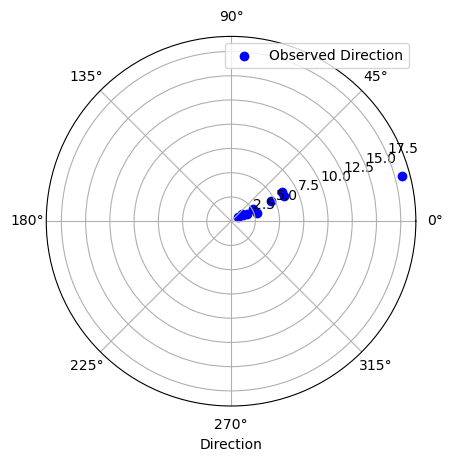

In [7]:

# Create a polar plot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

# Plot the observed direction, with speed magnitude as the radial coordinate
ax.scatter(direction_observed, speed_observed, c='blue', label='Observed Direction')

# Plot the observed speed
#ax.scatter(speed_observed, np.ones_like(speed_observed), c='red', label='Observed Speed')

# Set the labels and title
ax.set_xlabel('Direction')
ax.set_ylabel('')

# Add a legend
ax.legend()

# Show the plot
plt.show()


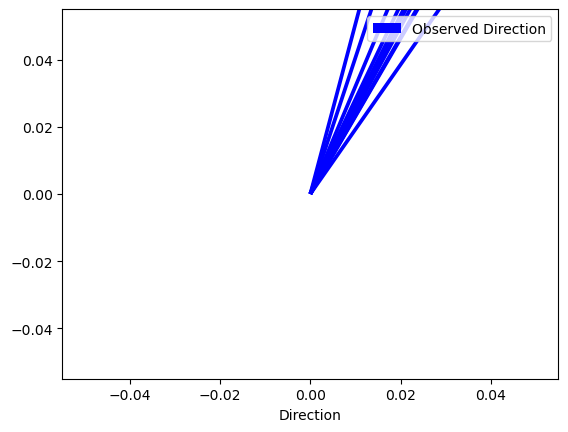

In [8]:


# Create a polar plot
fig, ax = plt.subplots()#subplot_kw={'projection': 'polar'})
# Convert polar coordinates to Cartesian coordinates
arrow_x = speed_observed * np.sin(direction_observed)
arrow_y = speed_observed * np.cos(direction_observed)


# Plot the observed direction as arrows pointing towards the center
ax.quiver(np.zeros_like(arrow_x), np.zeros_like(arrow_y), arrow_x, arrow_y,  angles='uv', scale_units='x', scale=1, color='blue', label='Observed Direction')

# Set the labels and title
ax.set_xlabel('Direction')
ax.set_ylabel('')

# Add a legend
ax.legend()

# Show the plot
plt.show()


In [9]:
# Set up priors for wind direction and speed
pr_mu_direction = 0
pr_sigma_direction = 0.1

pr_sigma_speed = 1

# currently uncorrelated speed and direction
with pm.Model() as direction_speed_model:
    # Define the circular transform for Wind Direction
    direction_transform = pm.distributions.transforms.circular

    # Define the prior distribution for Wind Direction
    direction = pm.Normal('direction', mu=pr_mu_direction, sigma=pr_sigma_direction, transform=direction_transform)

    # Define the prior distribution for Wind Speed
    speed = pm.HalfNormal('speed', sigma=pr_sigma_speed)

    # Generate the observed data for Wind Direction
    direction_obs = pm.Normal('direction_obs', mu=direction, sigma=0.1, observed=direction_observed)

    # Generate the observed data for Wind Speed
    speed_obs = pm.HalfNormal('speed_obs', sigma=speed, observed=speed_observed)



In [10]:
with direction_speed_model:
    trace = pm.sample(1000)
trace

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [direction, speed]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

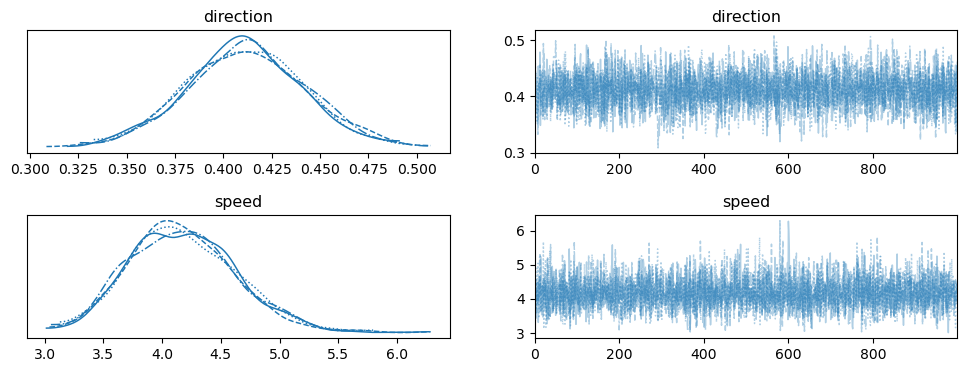

In [11]:
pm.plot_trace(trace, var_names=['direction', 'speed'])
plt.subplots_adjust(hspace=0.5)  # Adjust the vertical spacing between subplots
plt.show()


In [12]:
with direction_speed_model:
    posterior_predictive = pm.sample_posterior_predictive(trace=trace)
    trace.extend(posterior_predictive)


Sampling: [direction_obs, speed_obs]


In [14]:
# Downsample the trace.posterior using xarray
downsampled_trace = xr_downselect(trace.posterior_predictive, 'draw', 5).squeeze()

# Print the downsampled trace
print(downsampled_trace)


<xarray.Dataset>
Dimensions:              (chain: 4, draw: 200, direction_obs_dim_3: 10,
                          speed_obs_dim_3: 10)
Coordinates:
  * chain                (chain) int32 0 1 2 3
  * draw                 (draw) int32 0 5 10 15 20 25 ... 975 980 985 990 995
    direction_obs_dim_2  int32 0
  * direction_obs_dim_3  (direction_obs_dim_3) int32 0 1 2 3 4 5 6 7 8 9
    speed_obs_dim_2      int32 0
  * speed_obs_dim_3      (speed_obs_dim_3) int32 0 1 2 3 4 5 6 7 8 9
Data variables:
    direction_obs        (chain, draw, direction_obs_dim_3) float64 0.4584 .....
    speed_obs            (chain, draw, speed_obs_dim_3) float64 3.26 ... 2.127
Attributes:
    created_at:                 2023-12-23T13:03:34.566636
    arviz_version:              0.16.1
    inference_library:          pymc
    inference_library_version:  5.8.2


In [15]:
downsampled_trace['direction_obs'].sel({'chain':2})

<xarray.DataArray 'direction_obs' (draw: 200, direction_obs_dim_3: 10)>
array([[0.46619757, 0.61760858, 0.449288  , ..., 0.47835935, 0.64087507,
        0.15115964],
       [0.41090935, 0.42417126, 0.55415074, ..., 0.41428943, 0.42280165,
        0.39151446],
       [0.48267345, 0.36592561, 0.17283503, ..., 0.28406395, 0.37198853,
        0.24511677],
       ...,
       [0.51798349, 0.48723068, 0.55974141, ..., 0.57031573, 0.50735337,
        0.21176917],
       [0.50653489, 0.41746888, 0.46122272, ..., 0.49635894, 0.47841544,
        0.55623156],
       [0.35446348, 0.48022376, 0.36511019, ..., 0.34542967, 0.32211637,
        0.43251063]])
Coordinates:
    chain                int32 2
  * draw                 (draw) int32 0 5 10 15 20 25 ... 975 980 985 990 995
    direction_obs_dim_2  int32 0
  * direction_obs_dim_3  (direction_obs_dim_3) int32 0 1 2 3 4 5 6 7 8 9
    speed_obs_dim_2      int32 0

C:\Users\willi\AppData\Local\Temp\ipykernel_2932\3079054372.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])


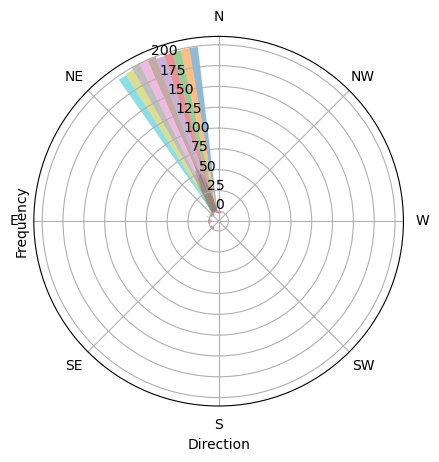

In [16]:
import numpy as np

# Create a polar histogram
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.set_theta_zero_location('N')

# Plot the histogram with the direction offset for each chain
for chain in downsampled_trace['direction_obs'].chain:
    ax.hist((downsampled_trace['direction_obs'].sel({'chain':chain})) % (2 * np.pi), bins=10, alpha=0.5)
    arr_CM = plt.arrow(chain*45*np.pi/180, -1.7, 0.0, 1, color='red', width=0.1, head_width=0.5, alpha=0.5)

# Set the labels and title
ax.set_xlabel('Direction')
ax.set_ylabel('Frequency')

# Set the direction labels
ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])


# Show the plot
plt.show()


C:\Users\willi\AppData\Local\Temp\ipykernel_2932\3552283520.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])
C:\Users\willi\AppData\Local\Temp\ipykernel_2932\3552283520.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])
C:\Users\willi\AppData\Local\Temp\ipykernel_2932\3552283520.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])
C:\Users\willi\AppData\Local\Temp\ipykernel_2932\3552283520.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabel

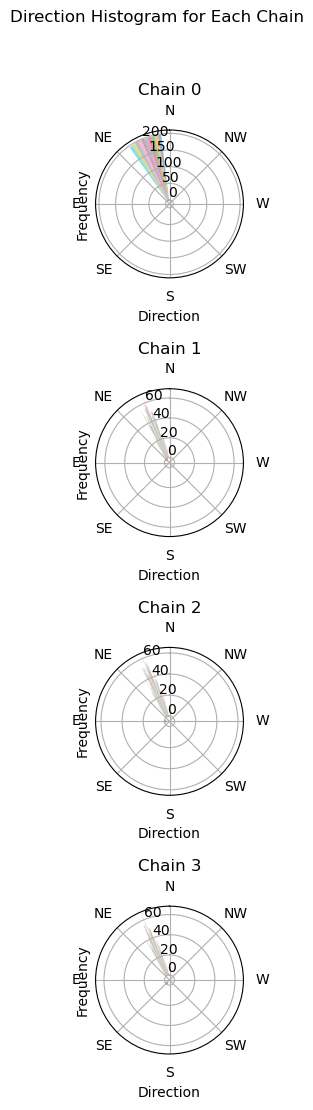

In [36]:
fig, axs = plt.subplots(len(downsampled_trace['direction_obs'].chain), 1, figsize=(10, 12), subplot_kw={'projection': 'polar'})
fig.suptitle('Direction Histogram for Each Chain')

# Iterate over each chain and plot the histogram
for i, chain in enumerate(downsampled_trace['direction_obs'].chain):
    ax = axs[i]
    ax.set_theta_zero_location('N')

    # Plot the histogram with the direction offset for the current chain
    ax.hist((downsampled_trace['direction_obs'].sel({'chain': chain})) % (2 * np.pi), bins=10, alpha=0.5)
    arr_CM = ax.arrow(chain * 45 * np.pi / 180, -1.7, 0.0, 1, color='red', width=0.1, head_width=0.5, alpha=0.5)

    # Set the labels and title for the current subplot
    ax.set_xlabel('Direction')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Chain {i}')

    # Set the direction labels
    ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])

# Make the plot interactive
plt.ion()
plt.subplots_adjust(hspace=0.75)
# Show the plot
plt.show()


IntSlider(value=0, max=3)

C:\Users\willi\AppData\Local\Temp\ipykernel_2932\1768754182.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])


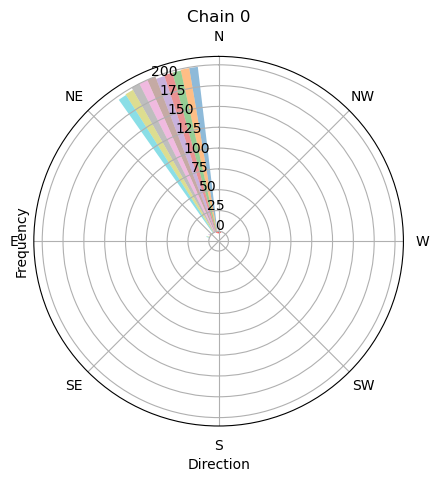

C:\Users\willi\AppData\Local\Temp\ipykernel_2932\1768754182.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])


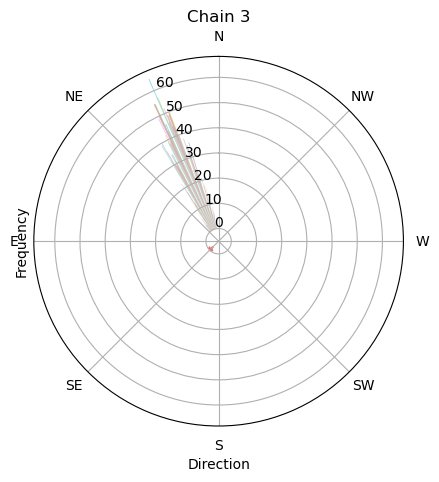

In [38]:
import ipywidgets as widgets
from IPython.display import display
# Create a function to display the plot for a specific chain
def plot_chain(chain):
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    ax.set_theta_zero_location('N')

    # Plot the histogram with the direction offset for the current chain
    ax.hist((downsampled_trace['direction_obs'].sel({'chain': chain})) % (2 * np.pi), bins=10, alpha=0.5)
    arr_CM = ax.arrow(chain * 45 * np.pi / 180, -1.7, 0.0, 1, color='red', width=0.1, head_width=0.5, alpha=0.5)

    # Set the labels and title for the current subplot
    ax.set_xlabel('Direction')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Chain {chain}')

    # Set the direction labels
    ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])

    # Show the plot
    plt.show()

# Create the widget
chain_widget = widgets.IntSlider(min=0, max=len(downsampled_trace['direction_obs'].chain)-1, step=1, value=0)

# Display the widget and the initial plot
display(chain_widget)
plot_chain(chain_widget.value)

# Update the plot when the widget value changes
def update_plot(change):
    plot_chain(change.new)

chain_widget.observe(update_plot, 'value')


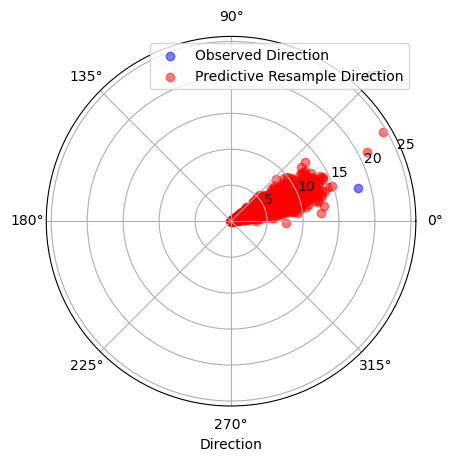

In [18]:
# Create a polar plot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

# Plot the observed direction, with speed magnitude as the radial coordinate
ax.scatter(direction_observed, speed_observed, c='blue', label='Observed Direction', alpha=0.5)

#plot the posterior predictive
ax.scatter(downsampled_trace['direction_obs'], downsampled_trace['speed_obs'], c='red', label='Predictive Resample Direction', alpha=0.5)

# Set the labels and title
ax.set_xlabel('Direction')
ax.set_ylabel('')

# Add a legend
ax.legend()

# Show the plot
plt.show()


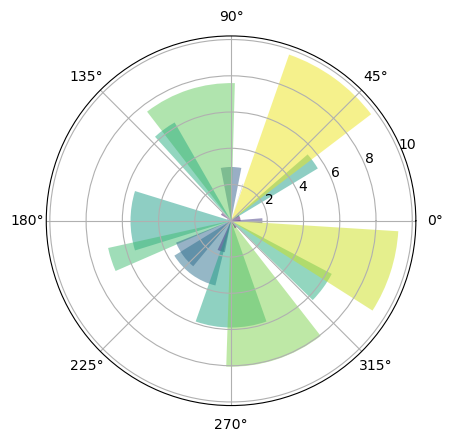

In [19]:

# Compute pie slices
N = 20
theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)
radii = 10 * np.random.rand(N)
width = np.pi / 4 * np.random.rand(N)
colors = plt.cm.viridis(radii / 10.)

ax = plt.subplot(projection='polar')
ax.bar(theta, radii, width=width, bottom=0.0, color=colors, alpha=0.5)

plt.show()